In [20]:
!pip install transformers[torch] datasets -q


In [21]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [22]:
dataset = load_dataset("flaviagiammarino/path-vqa")


In [23]:
dataset


DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})

Question: what are stained here with an immunohistochemical stain for cytokeratin 7?
Answer: bile duct cells and canals of hering


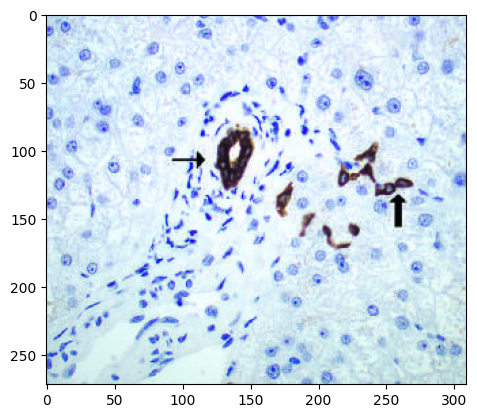

In [24]:
sample = dataset['train'][1]
PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [25]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")


In [26]:
train_data = dataset['train'].select(range(10000))
val_data = dataset['validation'].select(range(1000))

In [27]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding

In [28]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

In [29]:
train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

val_vqa_dataset = VQADataset(data=train_data,
                     segment='validation',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

In [30]:
train_vqa_dataset[0]


{'input_ids': tensor([  101,  2073,  2024, 11290,  7872,  4442,  1006,  9242,  4442,  1007,
         2284,  1029,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[0.6895, 0.8647, 0.9814,  ..., 0.9668, 1.2150, 1.4194],
         [1.0252, 0.9814, 1.0106,  ..., 1.0398, 1.3902, 1.2880],
         [0.9960, 1.0836, 0.8501,  ..., 1.0398, 1.2442, 1.1420],
         ...,
         [0.9668, 0.5581, 0.0617,  ..., 1.0106, 0.9376, 0.8792],
         [0.7917, 0.9960, 0.8647,  ..., 1.1420, 1.0252, 0.9230],
         [0.5581, 0.9522, 0.9376,  ..., 1.1420, 0.9376, 0.9668]],

        [[1.1594, 1.3995, 1.5196,  ..., 1.3695, 1.6247, 1.8948],
         [1.5946, 1.4746, 1.5046,  ..., 1.4446, 1.8047, 1.6847],
         [1.5196, 1.5946, 1.5196,  ..., 1.47

In [31]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=32,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=32,
                            shuffle=False)

In [32]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([32, 32])
attention_mask torch.Size([32, 32])
pixel_values torch.Size([32, 3, 128, 128])
labels torch.Size([32, 32])


In [39]:
device = torch.device("cuda:1")

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )
model.to(device)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [40]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] what are stained here with an immunohistochemical stain for cytokeratin 7? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] bile duct cells and canals of hering [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


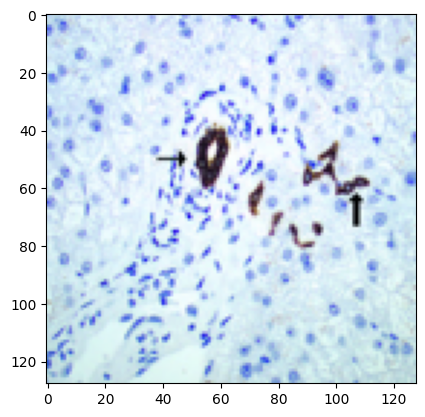

In [41]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [36]:
!pip install nltk

In [37]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


In [42]:
from transformers import PreTrainedTokenizerFast

# Ensure you have a tokenizer for decoding
tokenizer = PreTrainedTokenizerFast.from_pretrained("Salesforce/blip-vqa-base")

model.train()
for epoch in range(120):
    print(f"Epoch: {epoch}")
    total_loss = []
    total_bleu = 0
    total_samples = 0

    for batch in tqdm(train_dataloader):
        # Move data to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


        with torch.no_grad():
            # Generate predictions
            predictions = model.generate(
                pixel_values=batch["pixel_values"],
                input_ids=batch["input_ids"]
            )

            # Decode predictions and labels
            predicted_texts = [tokenizer.decode(pred, skip_special_tokens=True) for pred in predictions]
            label_texts = [tokenizer.decode(label, skip_special_tokens=True) for label in batch["labels"]]

            # Calculate BLEU for each sample in the batch
            for pred_text, label_text in zip(predicted_texts, label_texts):
                reference = [label_text.split()]  
                candidate = pred_text.split()  
                bleu_score = sentence_bleu(
                    reference,
                    candidate,
                    smoothing_function=SmoothingFunction().method1
                )
                total_bleu += bleu_score

            total_samples += len(batch["labels"])

    # Calculate epoch BLEU score
    avg_bleu = total_bleu / total_samples
    print(f"Loss: {sum(total_loss):.4f}, BLEU: {avg_bleu:.4f}")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Epoch: 0


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 487.9054, BLEU: 0.0651
Epoch: 1


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 89.6114, BLEU: 0.0641
Epoch: 2


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 68.7456, BLEU: 0.0692
Epoch: 3


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 54.5241, BLEU: 0.0705
Epoch: 4


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 44.3870, BLEU: 0.0746
Epoch: 5


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 37.1984, BLEU: 0.0776
Epoch: 6


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 31.7522, BLEU: 0.0800
Epoch: 7


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 28.2959, BLEU: 0.0801
Epoch: 8


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 25.6435, BLEU: 0.0888
Epoch: 9


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 25.4053, BLEU: 0.0913
Epoch: 10


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 21.9551, BLEU: 0.0888
Epoch: 11


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 20.4835, BLEU: 0.0913
Epoch: 12


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 19.5788, BLEU: 0.0911
Epoch: 13


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 18.7219, BLEU: 0.1024
Epoch: 14


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 18.5217, BLEU: 0.0974
Epoch: 15


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 17.7184, BLEU: 0.1076
Epoch: 16


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 18.0151, BLEU: 0.1113
Epoch: 17


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 17.8028, BLEU: 0.1070
Epoch: 18


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 17.4626, BLEU: 0.1073
Epoch: 19


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 17.3707, BLEU: 0.1081
Epoch: 20


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 17.7760, BLEU: 0.1036
Epoch: 21


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 16.9680, BLEU: 0.0877
Epoch: 22


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 15.7929, BLEU: 0.0883
Epoch: 23


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 16.1536, BLEU: 0.0925
Epoch: 24


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 15.4818, BLEU: 0.0937
Epoch: 25


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 15.3640, BLEU: 0.0972
Epoch: 26


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.9827, BLEU: 0.1023
Epoch: 27


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.8454, BLEU: 0.1003
Epoch: 28


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.7035, BLEU: 0.1041
Epoch: 29


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.2554, BLEU: 0.1167
Epoch: 30


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.6690, BLEU: 0.1148
Epoch: 31


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.5668, BLEU: 0.1142
Epoch: 32


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 16.2720, BLEU: 0.0967
Epoch: 33


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.9553, BLEU: 0.1094
Epoch: 34


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.3404, BLEU: 0.1150
Epoch: 35


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.6519, BLEU: 0.1154
Epoch: 36


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.6538, BLEU: 0.1173
Epoch: 37


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.5120, BLEU: 0.1248
Epoch: 38


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.5500, BLEU: 0.1217
Epoch: 39


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.7981, BLEU: 0.1174
Epoch: 40


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 16.8666, BLEU: 0.1152
Epoch: 41


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.9917, BLEU: 0.1150
Epoch: 42


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 15.6797, BLEU: 0.1169
Epoch: 43


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.8215, BLEU: 0.1119
Epoch: 44


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.8360, BLEU: 0.1195
Epoch: 45


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.5943, BLEU: 0.1055
Epoch: 46


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 15.5989, BLEU: 0.1119
Epoch: 47


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 15.6309, BLEU: 0.1098
Epoch: 48


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 15.1162, BLEU: 0.1180
Epoch: 49


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.5154, BLEU: 0.1132
Epoch: 50


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.2610, BLEU: 0.1185
Epoch: 51


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.5750, BLEU: 0.1197
Epoch: 52


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.2411, BLEU: 0.1124
Epoch: 53


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.5889, BLEU: 0.1167
Epoch: 54


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.7237, BLEU: 0.1028
Epoch: 55


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.9246, BLEU: 0.0947
Epoch: 56


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.2342, BLEU: 0.0984
Epoch: 57


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.1818, BLEU: 0.1081
Epoch: 58


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.2977, BLEU: 0.1114
Epoch: 59


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.9744, BLEU: 0.1144
Epoch: 60


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.3179, BLEU: 0.1135
Epoch: 61


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.3858, BLEU: 0.1014
Epoch: 62


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.0342, BLEU: 0.0986
Epoch: 63


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.7657, BLEU: 0.1078
Epoch: 64


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.0751, BLEU: 0.1052
Epoch: 65


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.7001, BLEU: 0.1097
Epoch: 66


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.6231, BLEU: 0.1110
Epoch: 67


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.5571, BLEU: 0.1116
Epoch: 68


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.1040, BLEU: 0.1140
Epoch: 69


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.8189, BLEU: 0.1042
Epoch: 70


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.6113, BLEU: 0.1125
Epoch: 71


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.4817, BLEU: 0.1227
Epoch: 72


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.7045, BLEU: 0.0957
Epoch: 73


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 15.3731, BLEU: 0.0889
Epoch: 74


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.4580, BLEU: 0.1068
Epoch: 75


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 16.0213, BLEU: 0.1037
Epoch: 76


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.9743, BLEU: 0.1018
Epoch: 77


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.6416, BLEU: 0.0977
Epoch: 78


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 16.1924, BLEU: 0.1008
Epoch: 79


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.8727, BLEU: 0.1019
Epoch: 80


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.5837, BLEU: 0.1010
Epoch: 81


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.2971, BLEU: 0.0994
Epoch: 82


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 23.1960, BLEU: 0.0836
Epoch: 83


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 30.1996, BLEU: 0.0694
Epoch: 84


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 20.3152, BLEU: 0.0917
Epoch: 85


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 16.1434, BLEU: 0.1025
Epoch: 86


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 15.4333, BLEU: 0.1028
Epoch: 87


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 14.2342, BLEU: 0.0978
Epoch: 88


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.9276, BLEU: 0.1053
Epoch: 89


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.2850, BLEU: 0.1012
Epoch: 90


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.7048, BLEU: 0.1000
Epoch: 91


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.7081, BLEU: 0.1082
Epoch: 92


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.5422, BLEU: 0.1213
Epoch: 93


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.6824, BLEU: 0.1142
Epoch: 94


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.4716, BLEU: 0.1144
Epoch: 95


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.7011, BLEU: 0.1108
Epoch: 96


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.6444, BLEU: 0.1147
Epoch: 97


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.8688, BLEU: 0.1163
Epoch: 98


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.5180, BLEU: 0.1087
Epoch: 99


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.5656, BLEU: 0.1146
Epoch: 100


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 13.0422, BLEU: 0.1035
Epoch: 101


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.7792, BLEU: 0.0956
Epoch: 102


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.6920, BLEU: 0.0945
Epoch: 103


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.8930, BLEU: 0.0887
Epoch: 104


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.2257, BLEU: 0.0904
Epoch: 105


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.0829, BLEU: 0.0915
Epoch: 106


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.0199, BLEU: 0.0987
Epoch: 107


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.0978, BLEU: 0.0941
Epoch: 108


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 11.9945, BLEU: 0.0935
Epoch: 109


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.0271, BLEU: 0.0927
Epoch: 110


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 11.9482, BLEU: 0.0939
Epoch: 111


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.3322, BLEU: 0.0891
Epoch: 112


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.5061, BLEU: 0.0981
Epoch: 113


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.5261, BLEU: 0.0994
Epoch: 114


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.3853, BLEU: 0.0989
Epoch: 115


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.5083, BLEU: 0.0989
Epoch: 116


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.1951, BLEU: 0.1004
Epoch: 117


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 12.3557, BLEU: 0.0917
Epoch: 118


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 36.1395, BLEU: 0.0561
Epoch: 119


  0%|          | 0/313 [00:00<?, ?it/s]

Loss: 37.1735, BLEU: 0.0491


In [18]:
print(outputs.keys())


odict_keys(['loss', 'image_embeds', 'last_hidden_state'])


Question:  where are liver stem cells ( oval cells ) located?
Predicted Answer:  yes
Actual Answer:  in the canals of hering


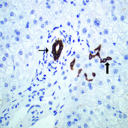

###################################################################
Question:  what are stained here with an immunohistochemical stain for cytokeratin 7?
Predicted Answer:  yes
Actual Answer:  bile duct cells and canals of hering


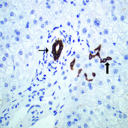

###################################################################
Question:  what do the areas of white chalky deposits represent?
Predicted Answer:  yes
Actual Answer:  foci of fat necrosis


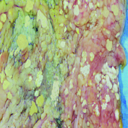

###################################################################
Question:  is embolus derived from a lower - extremity deep venous thrombus lodged in a pulmonary artery branch?
Predicted Answer:  yes
Actual Answer:  yes


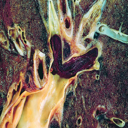

###################################################################
Question:  how is hyperplasia without atypia characterized?
Predicted Answer:  yes
Actual Answer:  by nests of closely packed glands


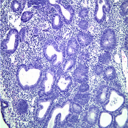

###################################################################
Question:  is normal palmar creases present?
Predicted Answer:  yes
Actual Answer:  no


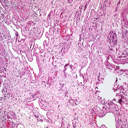

###################################################################
Question:  where is this from?
Predicted Answer:  yes
Actual Answer:  gastrointestinal system


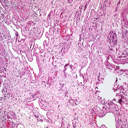

###################################################################
Question:  what is present?
Predicted Answer:  yes
Actual Answer:  gastrointestinal


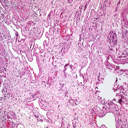

###################################################################
Question:  what is present?
Predicted Answer:  yes
Actual Answer:  esophagus


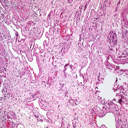

###################################################################
Question:  what is present?
Predicted Answer:  yes
Actual Answer:  varices


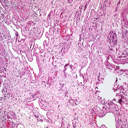

###################################################################


In [44]:
# add batch dimension + move to GPU|
for x in range(10):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")